# A simple Product Recommendation process based on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project and practical application

Any decent recommender model would have been trained using data from millions of products. For companies like Amazon, sich large amounts of data is easy to come by. But that's not all now is it? Can the same recommender model be used for years at a stretch without any modifications? Probably not. Products evolve over time. Companies do away with older products and bring in  newer ones every day. Companies like Amazon have the time and resources to ensure that their recommendation systems are up to date with the latest trends.

Moreover, neural networks are being used for recommender systems. These models are designed using sophisticated state of the art architecture. The model needs to be designed first. Then it will be tested and modified again and again. Fine tuning deep learning models can be a monumental task. Now, what if I told you that we could come up with a decent recommender process that involves no training at all? Sounds too good to be true? Well, thanks to __[Google's universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ , this is possible! Given a product description as text, the input will be mapped to a high dimensional vector of length 512. These "embeddings" are then used to compute similarities based on which practical recommendations can be made

### Outline of the entire process:

1. Obtain the data from this __[webiste](http://jmcauley.ucsd.edu/data/amazon/links.html)__ and more specifically, this  __[link](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Clothing_Shoes_and_Jewelry.json.gz)__ for the data.
2. Clean the data for analysis.
3. Remove stop words from product descriptions.
4. Convert the descriptions column to a list and have that run through __[Tensorflow's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ . This computes a numpy array of length 512 for each movie plot.
5. Calculate the cosine similarities matrix using the above generated numpy array for the 9 most similar product descriptions.
6. Plot the images of the movies using the url in the source file.
7. Analyze genres and possibly the plot descriptions as well.

### A brief introduction to the Universal Sentence Encoder

This encoder encodes words, phrases, sentences or even paragraphs into high dimensional space. This model was trained extensively using various data sources to accomlish various NLP (Natural Language Processing tasks). 

The input word, phrase, or sentence is converted to a vector of size 512. This vector is represented though a numpy array. What's so special about this encoder is that it maintains context similarity in a semantic sense which can be very useful. For ex, we have the three sentences:

1) How old are you?
2) How are you?
3) What is your age

We know that sentences 1 and 3 are closer in a semantic sense. While sentences 1 and 2 differ only a word, they differ greatly in contrast. The universal sentence encoder was trained such that we compute any mathematical similarity between the 3 sentences, sentences 1 and 3 will be closer than 1 and 2. That's incredible isn't it?

For this project, I'll be using the __[universal-sentence-encoder-large](https://tfhub.dev/google/universal-sentence-encoder-large/3)__. This model was trained with a transformer encoder. We can hope to achive a high accuracy with this model but the tradeoff would be the computing time and memory usage. A lighter version of the universal sentence encoder can be found __[here](https://tfhub.dev/google/universal-sentence-encoder/2)__

In [3]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityajakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

### STEP 1

In [4]:
new_df = pd.read_csv('Clothing_file.csv')

In [5]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0                                              imUrl  \
0           0  http://ecx.images-amazon.com/images/I/41Nrta6E...   
1           1  http://ecx.images-amazon.com/images/I/419ED1sp...   
2           2  http://ecx.images-amazon.com/images/I/41qcR5%2...   
3           3  http://ecx.images-amazon.com/images/I/21hY4FKm...   
4           4  http://ecx.images-amazon.com/images/I/41IPc6iO...   

                                               title  \
0                Geneva Watch Face for Beading LWF26   
1     Iron Metal Dress Form Mannequin 29&quot; Brown   
2  Moneysworth and Best Shoe Care Neon Sport Lace...   
3    Operator Grade Field Jacket - Coyote Brown - XL   
4  Marquette University - Two-Toned Money Clip - ...   

                                         description  
0  Geneva watch face for beading.  This is a rect...  
1  Wrought Iron Metal Dress Form ~ Mannequin ~ Je...  
2  The colors are orange, lime and white. The col...  
3  The Operator Grade Field Jacket is soon to bec...  
4  Our Marquette University money clip is a hands...

In [11]:
len(new_df)

42685

We will now only choose the fields of interest

In [6]:
new_df = new_df[['imUrl','title', 'description']]

Dropping rows with NaN values

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [7]:
new_df['description_new'] = new_df['description'].str.replace(':', '').str.replace('\d+', ' ').str.replace('[', '').str.replace(']', '').str.replace('{\d+}', '').str.replace('.', '').str.replace('(', '').str.replace(')', '').str.replace(',', '').str.replace('-', '').str.replace('*', ' ').str.replace('{', ' ').str.replace('}', ' ').str.replace('!', ' ').str.replace('/', ' ').str.replace('+', ' ').str.replace('"', '').str.replace('  ', ' ').str.replace('   ', ' ').str.lower()

In [8]:
new_df['description_new'].loc[0]

'geneva watch face for beading this is a rectangle silver plated watch face with loops this has a white dial japan movement heavy silver plating and is water resistant the loops can be removed easily with pliers to beading directly to the watch face not including the loops this watch face measures  in length and about in width stems have been pulled to save battery life'

In [9]:
new_df['description_new'] = new_df['description_new'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

NameError: name 'stop' is not defined

In [10]:
new_df['description_new'].loc[10]

"hashed men's shirts from fox racingcasual shirt from fox racingfox racing motorcycle branded shirt tshirt tee tee shirt"

In [11]:
new_df = new_df.reset_index(drop = True)

In [12]:
len(new_df)

42685

In [13]:
new_df = new_df.reset_index(drop=True)

In [14]:
new_df.head()

imUrl  \
0  http://ecx.images-amazon.com/images/I/41Nrta6E...   
1  http://ecx.images-amazon.com/images/I/419ED1sp...   
2  http://ecx.images-amazon.com/images/I/41qcR5%2...   
3  http://ecx.images-amazon.com/images/I/21hY4FKm...   
4  http://ecx.images-amazon.com/images/I/41IPc6iO...   

                                               title  \
0                Geneva Watch Face for Beading LWF26   
1     Iron Metal Dress Form Mannequin 29&quot; Brown   
2  Moneysworth and Best Shoe Care Neon Sport Lace...   
3    Operator Grade Field Jacket - Coyote Brown - XL   
4  Marquette University - Two-Toned Money Clip - ...   

                                         description  \
0  Geneva watch face for beading.  This is a rect...   
1  Wrought Iron Metal Dress Form ~ Mannequin ~ Je...   
2  The colors are orange, lime and white. The col...   
3  The Operator Grade Field Jacket is soon to bec...   
4  Our Marquette University money clip is a hands...   

                                     description_new  
0  geneva watch face for beading this is a rectan...  
1  wrought iron metal dress form ~ mannequin ~ je...  
2  the colors are orange lime and white the color...  
3  the operator grade field jacket is soon to bec...  
4  our marquette university money clip is a hands...

In [26]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [27]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [28]:
all_descriptions = new_df['description_new'].tolist()

In [29]:
len(all_descriptions)

42685

In [30]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:30000]
set_4 = all_descriptions[30000:40000]
set_5 = all_descriptions[40000:]
full_set = [set_1, set_2, set_3, set_4, set_5]

In [31]:
tf.logging.set_verbosity(tf.logging.ERROR)
j=0
for i in full_set:
    j += 1
    with tf.device('/device:CPU:0'):      
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i))
            np.save('clothing_set_' + str(j) + '.npy', description_embeddings)            
            print(j)
#np.save('embed_10k.npy', description_embeddings)

1
2
3
4
5


In [24]:
set_1 = np.load('clothing_set_1.npy')
set_2 = np.load('clothing_set_2.npy')
set_3 = np.load('clothing_set_3.npy')
set_4 = np.load('clothing_set_4.npy')
set_5 = np.load('clothing_set_5.npy')

In [25]:
description_embeddings = np.concatenate([set_1, set_2, set_2, set_4, set_5])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [26]:
cos_matrix = cosine_similarity(description_embeddings)

In [27]:
cos_matrix.shape

(42685, 42685)

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [28]:
words_siilar = cos_matrix

In [29]:
words_siilar.shape

(42685, 42685)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [32]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [33]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [15]:
new_df['description'].loc[37509]

'Having been around for many years, Khombu is well-known and highly regarded in ski and mountain shops throughout the U.S when it comes to premiere "After Ski Footwear". Khombu footwear is technically engineered, weatherproof, and waterproof, combining the latest advanced materials and insulations with sporty styling.'

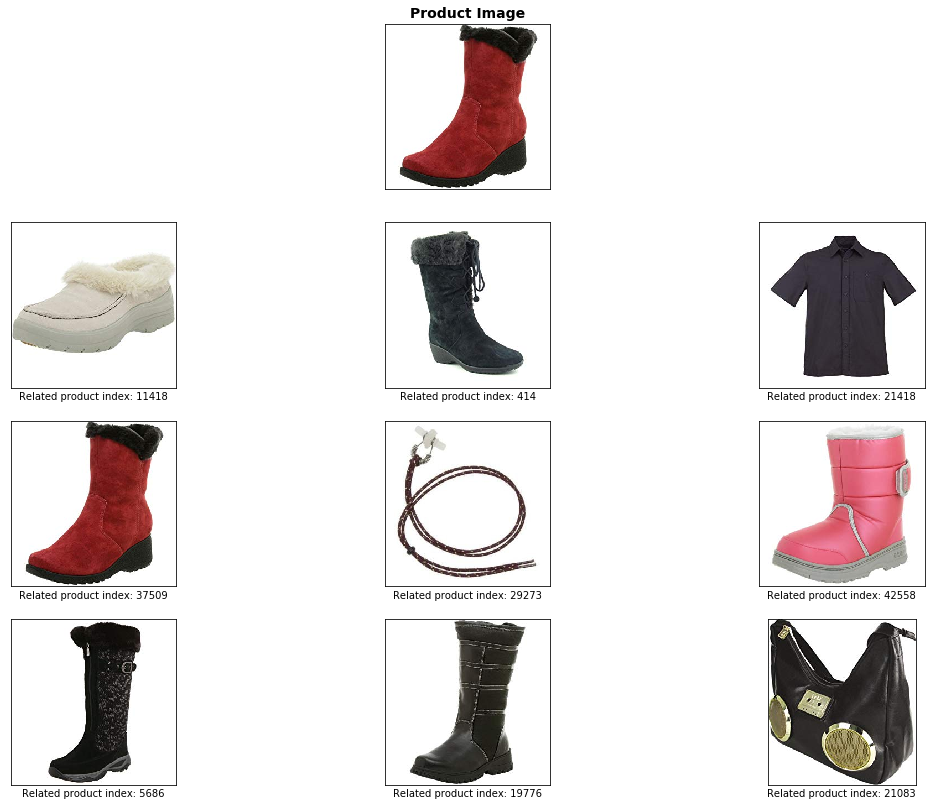

In [130]:
get_related_products(37509)

In [21]:
new_df['description'].loc[29273]

"The Harmony Tweaker Nose Plug keeps you from getting a bunch of water up your nose as you roll in the rapids. The Tweaker Plug's heavy-duty, spring-loaded nose closers provide a snug fit without digging holes in your nostrils. The Harmony Tweaker Nose Plug hangs on a line around your neck, so you can take it off without losing it when you're portaging.Product FeaturesCountry of origin: China"

In [20]:
new_df['description'].loc[21083]

'Fi-Hi BOHO Stereo Bag have a built-in 3000 milliW stereo amplifier and water resistant speakers for listening to music without headphones. Fi-Hi&#xED;s are open-source and easily connect to any iPod , mobile phone, MP3/CD player, hand held game or multi-media device with a 3.5mm stereo mini jack. Fi-Hi requires 4 - "AA" batteries that will provide over 6 hours of non-stop block-rockin&#xED; tunes.'

In [41]:
new_df['description'].loc[2486]

'With this stunning handmade jewelry set, all eyes will truly be on you as you make a grand entrance on your wedding day. Feel like a princess with the breathtaking beauty of so many sparkling diamond-cut gems in this silver and rhinestone set, giving you the look of high end designer jewelry at an affordable price. The All Eyes on You Designer Jewelry Set has an adjustable necklace of 13in-18in while the discreet drop earrings at 1.25in, this necklace and earring set is the perfect complement to your trousseau.'

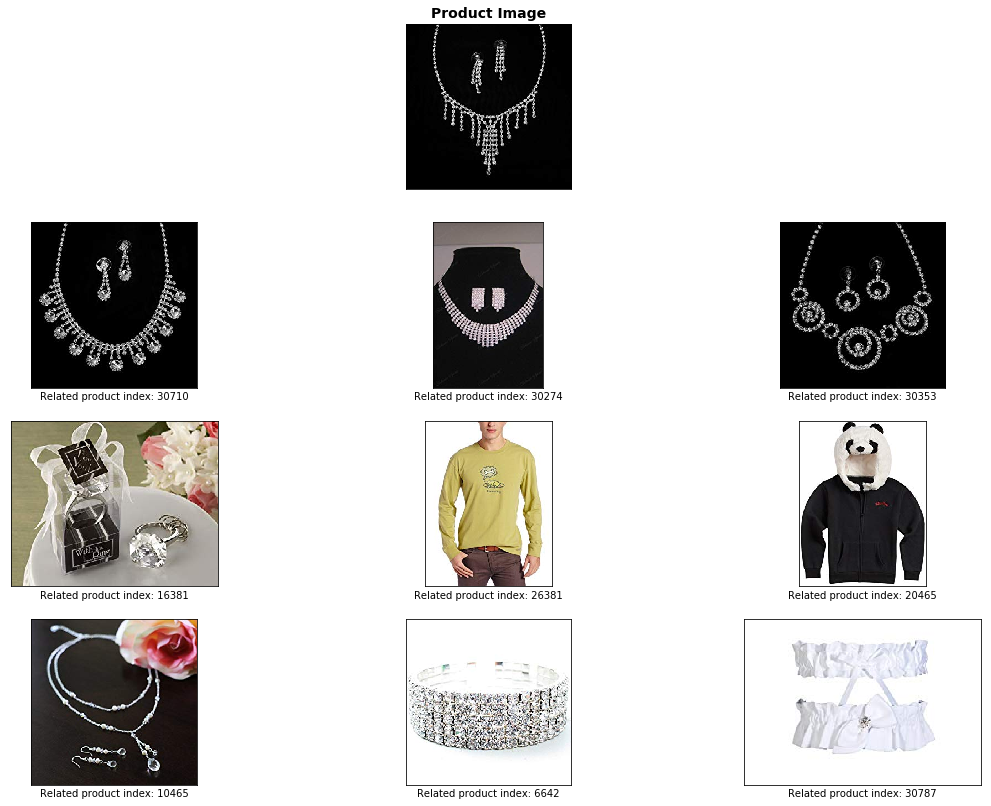

In [40]:
get_related_products(2486)

In [43]:
new_df['title'].loc[26381]

"Life is good Men's Crusher Dream Big Rocket Long Sleeve Tee"

In [46]:
new_df['title'].loc[762]

"Batman Arkham City Joker's Straightjacket Jumpsuit, White, Standard"

We have a **Star Wars** costume from **Rubie**. Let's see what we get as recommendations.

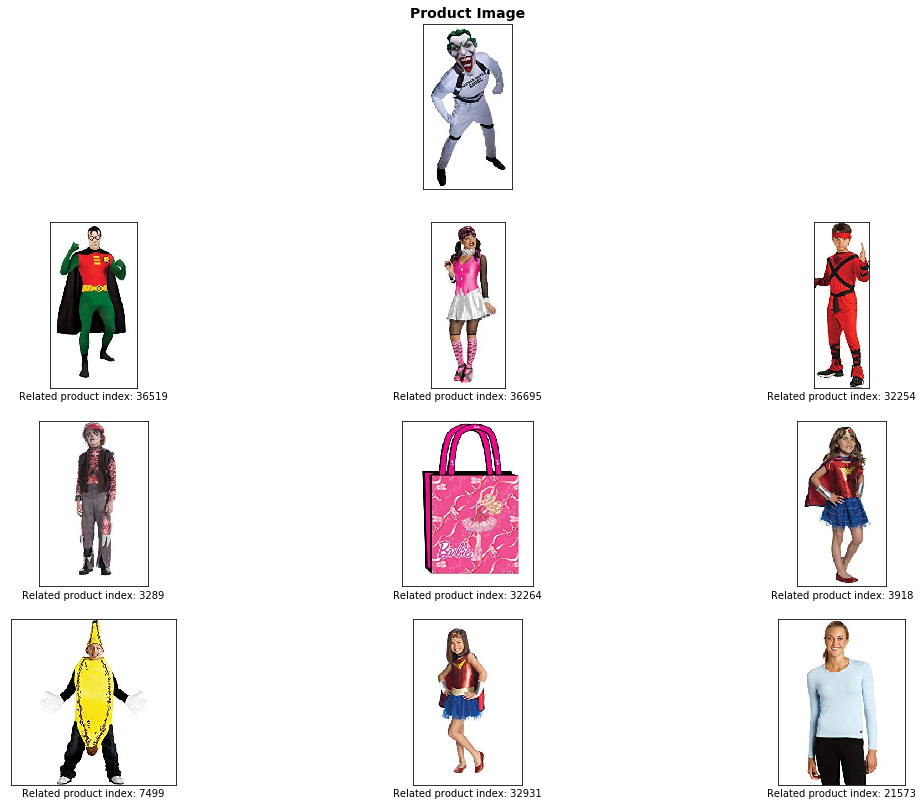

In [54]:
get_related_products(762)

In [47]:
new_df['title'].loc[6784]

"Helly Hansen Women's Kirkwall Rain Coat"

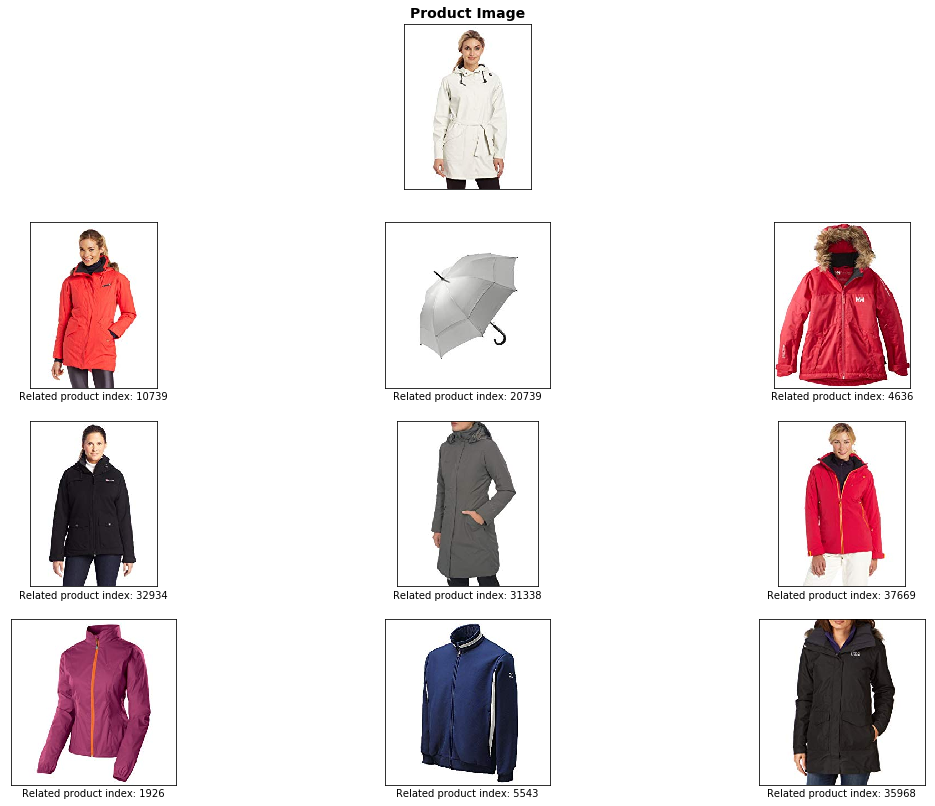

In [72]:
get_related_products(6784)

In [49]:
new_df['title'].loc[37559]

'Nirvanna Designs EA02 Snowflake Earmuffs with Faux Fur'

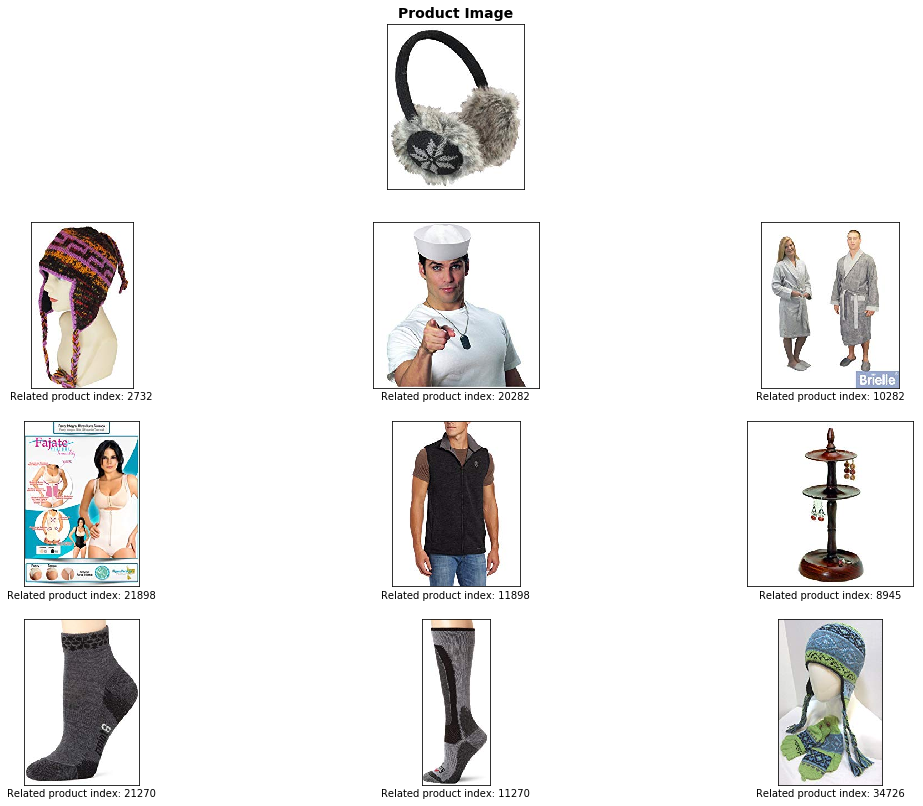

In [94]:
get_related_products(37559)

In [51]:
new_df['title'].loc[[20282]]

20282    White Sailor Hat
Name: title, dtype: object

And that wasn't even hard to call! We do get recommendations of ther Harry Potter merchandize.

In [52]:
new_df['title'].loc[11527]

'Venture Battery Powered Heated Glove Liners 7.4 Volt - Small - BX923 S'

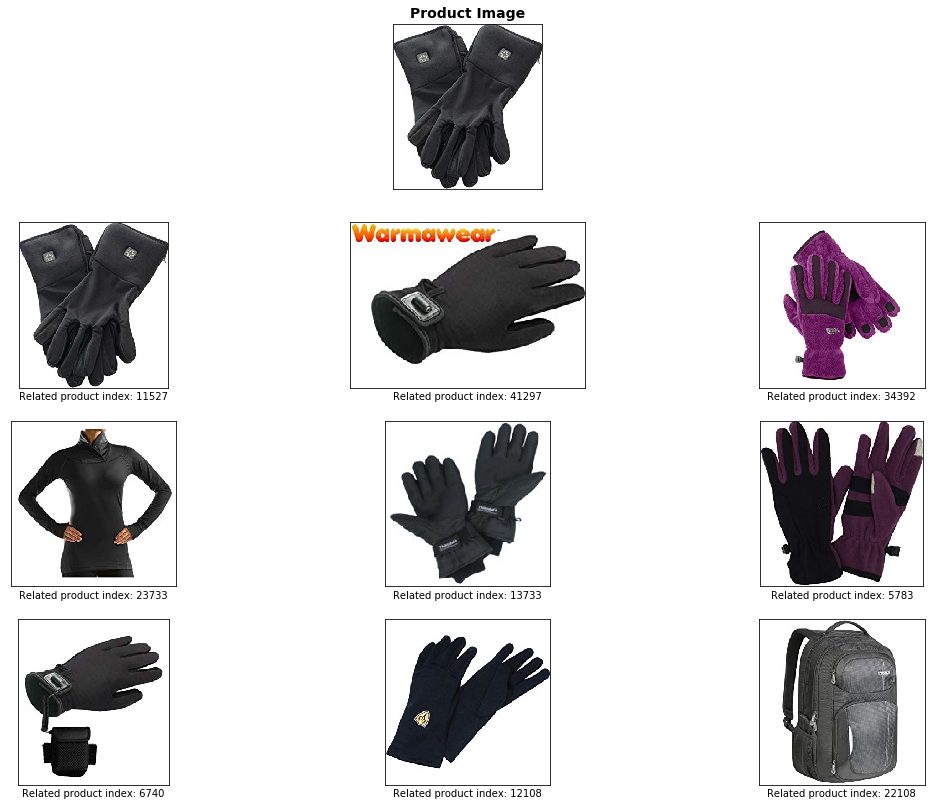

In [70]:
get_related_products(11527)

In [53]:
new_df['title'].loc[13873]

'Angry Birds Black Baseball Cap'

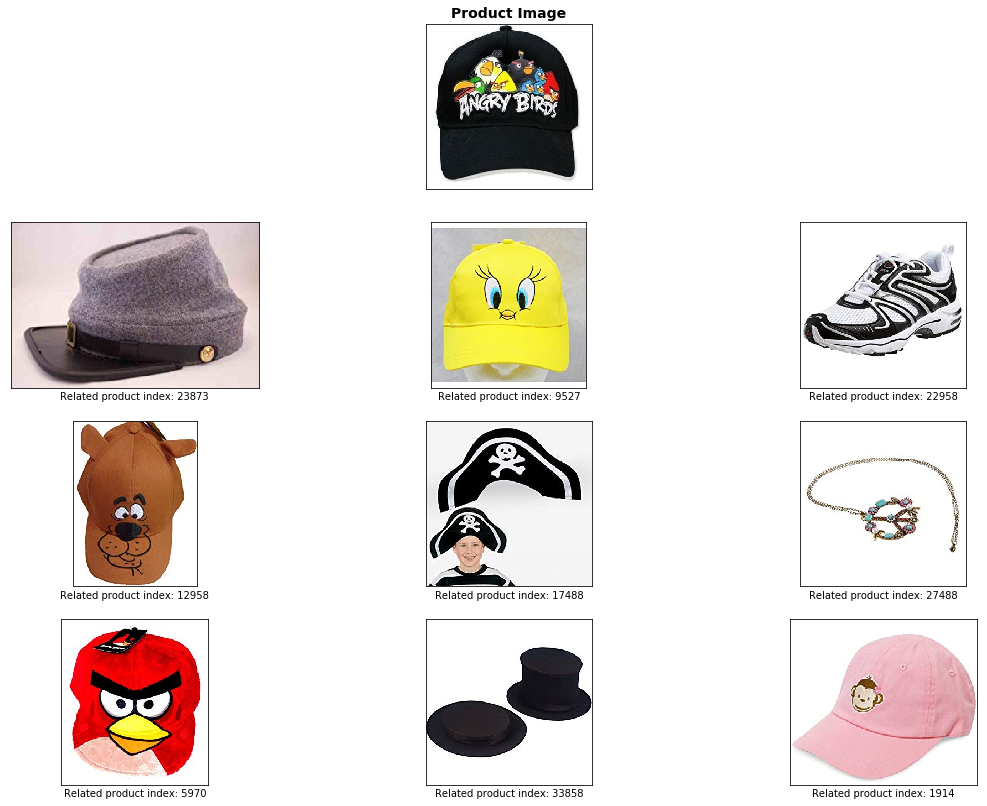

In [61]:
get_related_products(13873)

In [54]:
new_df['title'].loc[12044]

"New England Patriots -White- Women's Dazzle Trim Hooded Sweatshirt - Large"

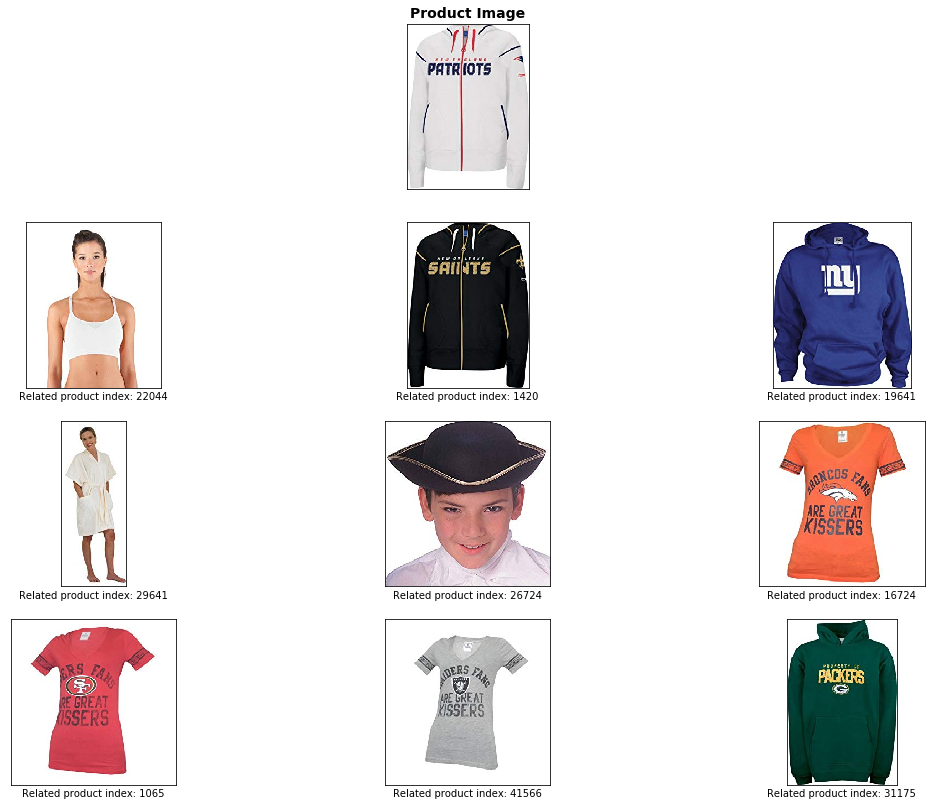

In [62]:
get_related_products(12044)

Indeed, we get recommendations of other **Superman** products.

In [55]:
new_df['title'].loc[13388]

'Disney Princess Pink Digital/ LCD Watch Princesses Cinderella, Tiana and Aurora'

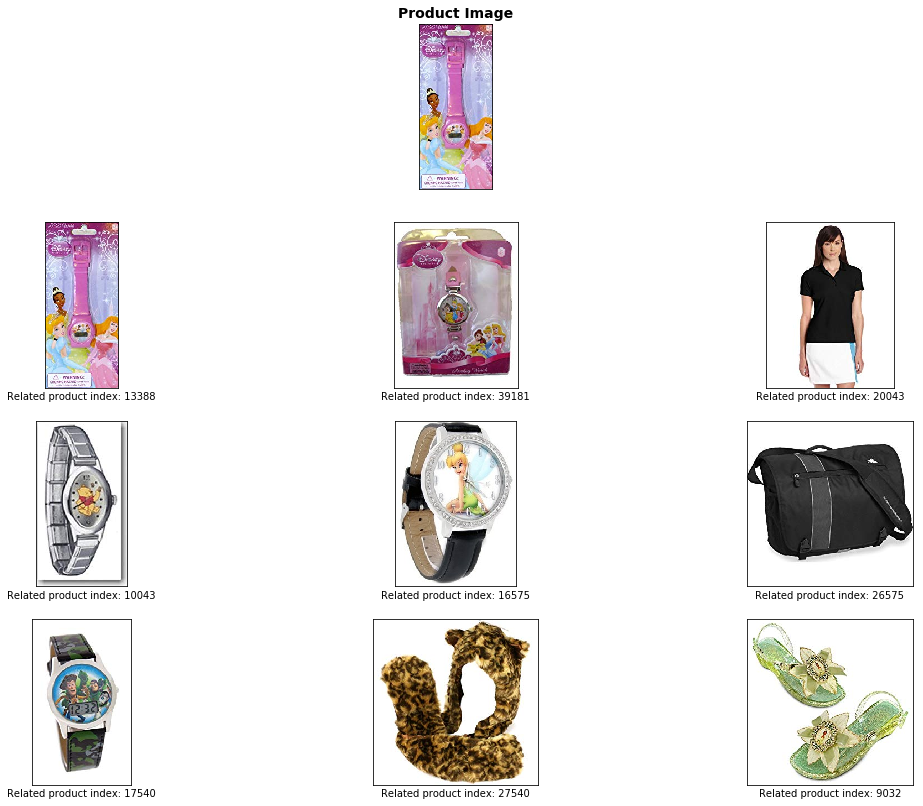

In [63]:
get_related_products(13388)

In [57]:
new_df['title'].loc[31224]

"Saban'S Power Rangers Samurai Gold Ranger Classic Muscle Costume, Blue/Gold/Silver, Medium 7 - 8 (child)"

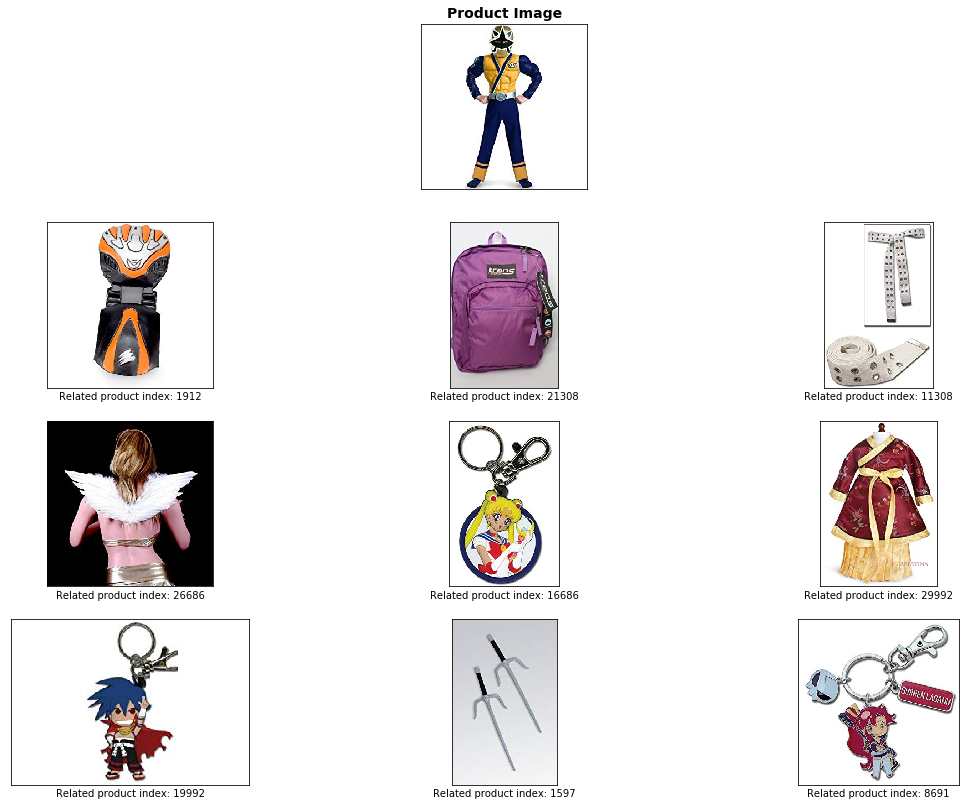

In [64]:
get_related_products(31224)

In [58]:
new_df['title'].loc[2014]

'The Big Bang Theory Bazinga Cape Socks Superman'

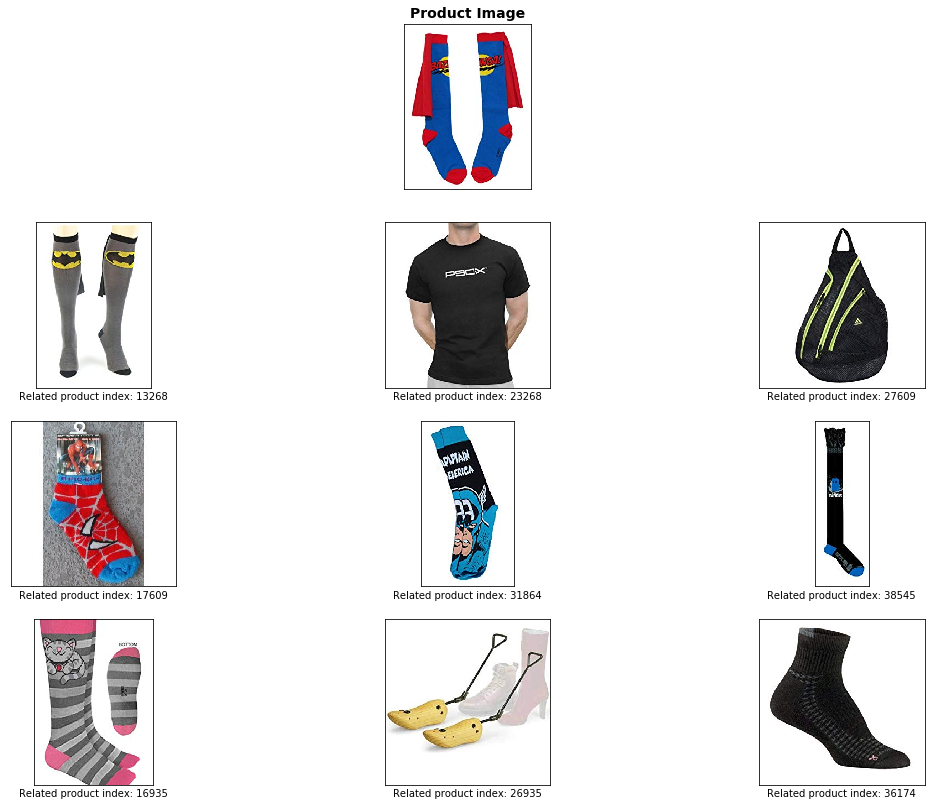

In [65]:
get_related_products(2014)

In [59]:
new_df['title'].loc[8562]

'Union Jack Cowboy Hat'

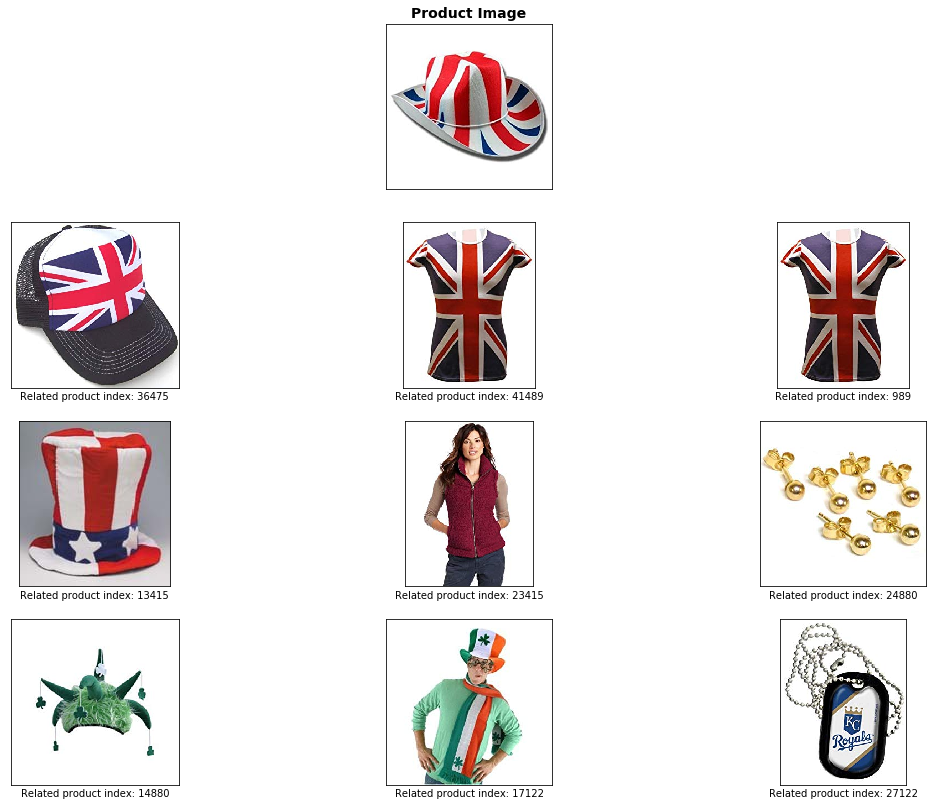

In [80]:
get_related_products(8562)

In [60]:
new_df['title'].loc[42516]

"Nike Women's Victory Dri Fit Tank (Perfect Pink/ White/ Matte Silver) - M"

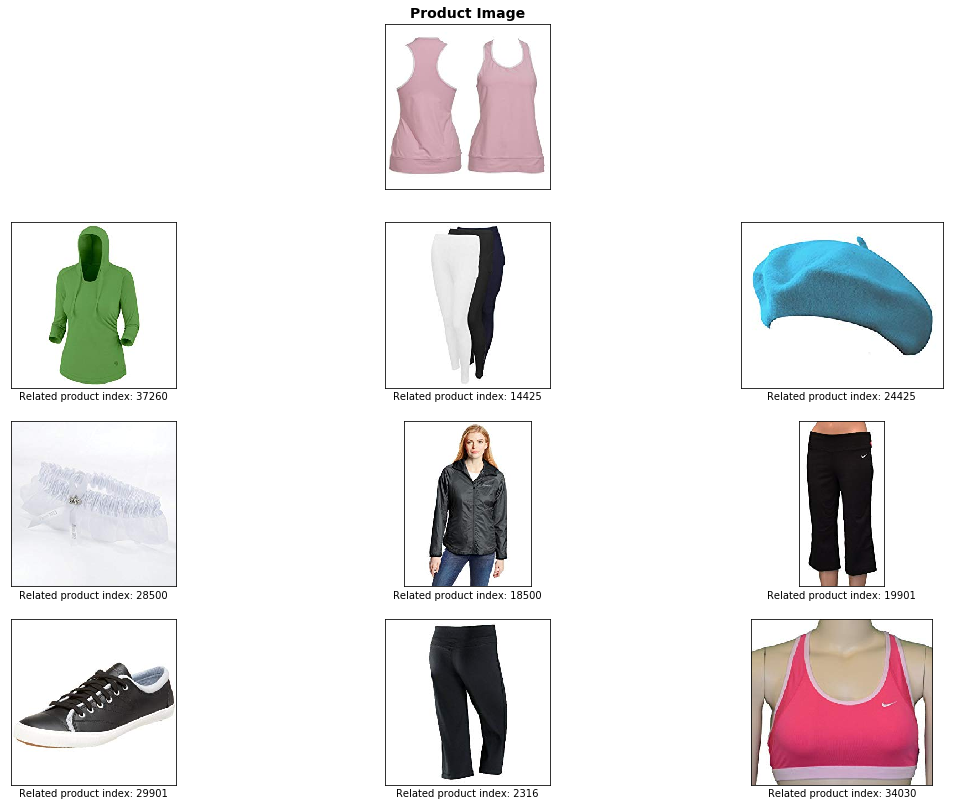

In [67]:
get_related_products(42516)

In [61]:
new_df['title'].loc[7468]

'ARCTERYX Rho Balaclava Hats &amp; headwear 000 Black'

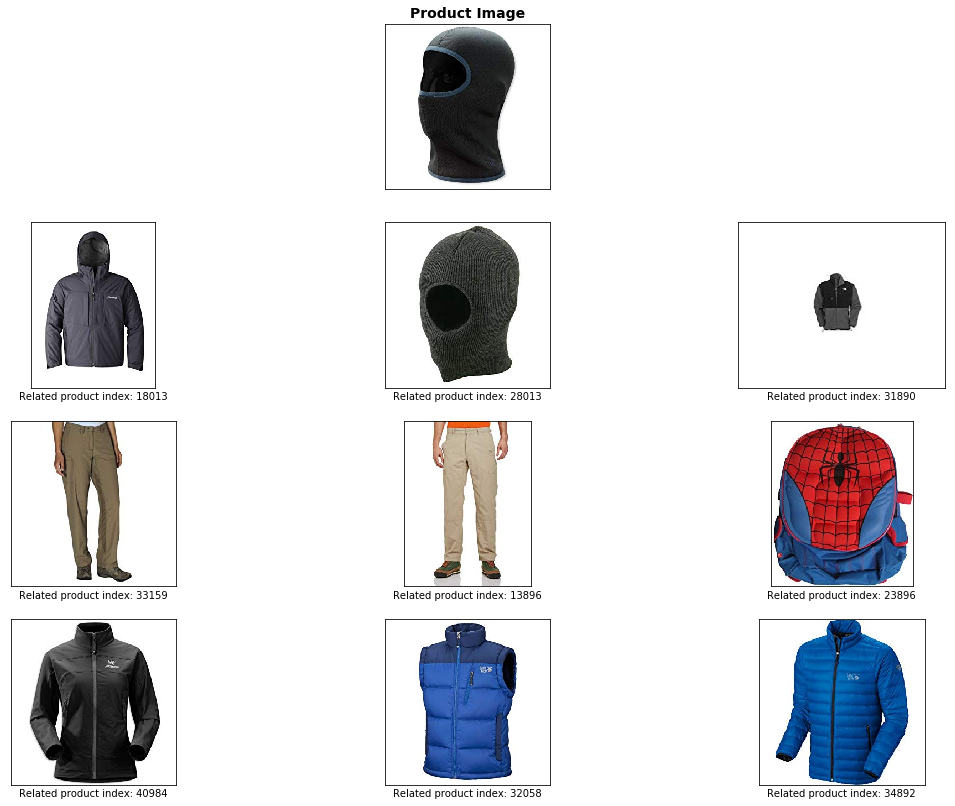

In [110]:
get_related_products(7468)

In [62]:
new_df['title'].loc[5959]

'MyLux Handbag 110517BKWH'

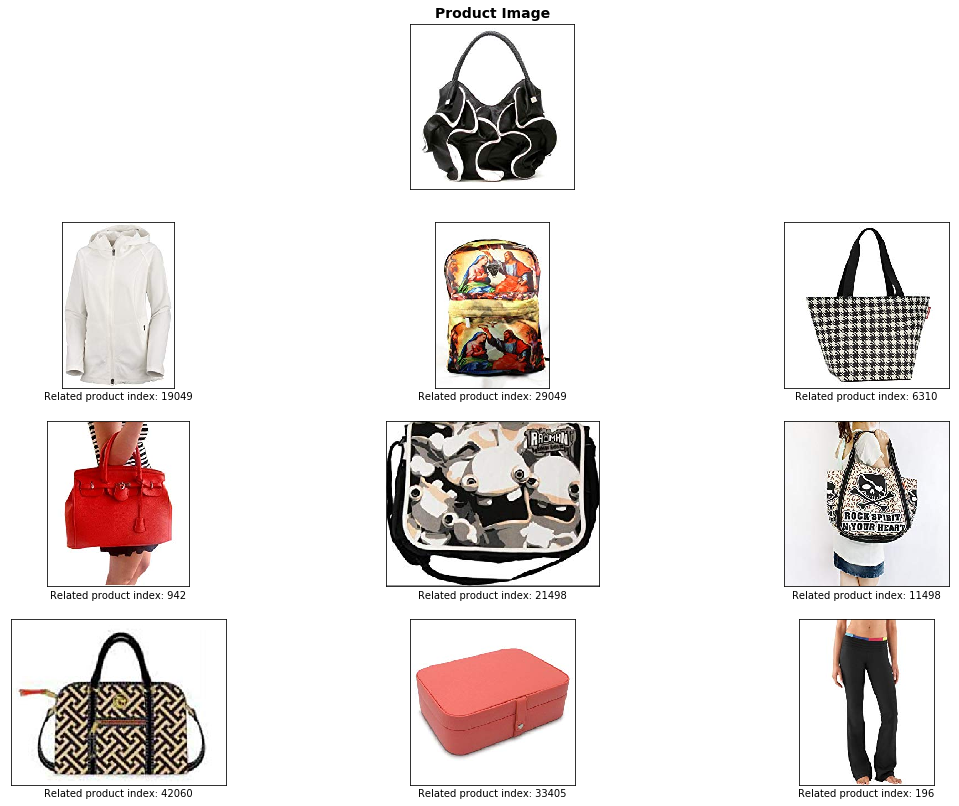

In [128]:
get_related_products(5959)